# **Project 2: CNNs**

# Table of Contents
* [Convolution](#convolution)
* [Horizontal Filtering](#Horizontal_filtering)
* [Gaussian Filter](#gaussian_filter)
* [Sharpening Filter](#sharpening_filter)
* [Convolusion Network](#convolusion_network)
* [Transfer Learning](#transfer_learning)
* [YOLO](#YOLO)
* [Transfer Learning vol.2](#transfer_learning_vol.2)


I will be using the chest xray classification dataset. It includes 4077 train, 582 test and 1165 validation images. The dataset is divided into normal and pneumonia images.

In [4]:
# Import
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import datetime
import os
import time

from datasets import load_dataset

from IPython.display import display, HTML, IFrame

%matplotlib inline

In [5]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

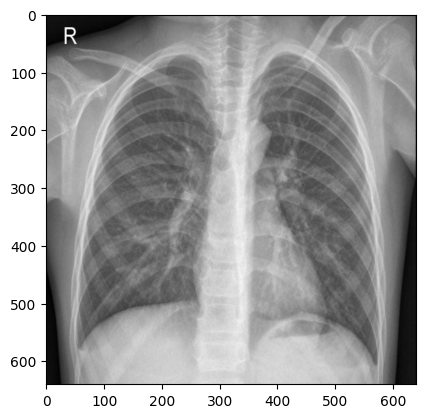

In [7]:
# Loading the dataset
ds = load_dataset("keremberke/chest-xray-classification",name = "full")
example = ds['train'][20]

plt.imshow(example['image'])
plt.show()


In [14]:
example

{'image_file_path': '/storage/hf-datasets-cache/all/datasets/60340657865253-config-parquet-and-info-keremberke-chest-xray-cla-9d66ea8b/downloads/extracted/8202f7dd6f1edf5e674abe75990eb233fbbca4408e132a3acd5268bd99708e15/NORMAL/IM-0037-0001_jpeg.rf.3cdd790e52653aa06a5e5baf6568bea1.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'labels': 0}

## Convolution  <a class="anchor" id="convolution"></a>

In [6]:
def zero_pad(X, pad):

    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),mode='constant' ,constant_values=(0,0))

    return X_pad

In [7]:
def conv_single_step(a_slice_prev,W,b):
    
    s = np.multiply(a_slice_prev,W)
    Z = np.sum(s)

    return Z + float(b.item(0))

In [8]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function

    Arguments:
    A_prev -- output activations of the previous layer,
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"

    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """

    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Retrieve dimensions from W's shape 
    (f, f, n_C_prev, n_C) = W.shape

    # Retrieve information from "hparameters" 
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    # Compute the dimensions of the CONV output volume using the formula given above.
    # Hint: use int() to apply the 'floor' operation. 
    n_H = int(int(n_H_prev + 2*pad - f)/stride + 1)
    n_W = int(int(n_W_prev + 2*pad - f)/stride + 1)

    # Initialize the output volume Z with zeros.
    Z = np.zeros([m, n_H, n_W, n_C])

    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)

    for i in range(m):                  # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]      # Select ith training example's padded activation
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" 
            vert_start = stride*h
            vert_end = vert_start + f

            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" 
                horiz_start = stride * w
                horiz_end = horiz_start + f
                for c in range(n_C):   # loop over channels (= #filters) of the output volume

                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = A_prev_pad[i,vert_start:vert_end,horiz_start:horiz_end,:]

                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    weights = W[:,:,:,c]
                    biases = b[:,:,:,c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev,weights,biases)
    ### END CODE HERE ###

    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))

    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)

    return Z, cache

### **Horizontal filtering** <a id="horizontal_filtering"></a>

In [9]:
def horizontal_filter(img,hparameters,b):
    
    filter = np.array([[1,1,1,1,1],[1,1,1,1,1],[0,0,0,0,0],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]]) # 5x5 horizontal filter
    filter = np.stack([filter,filter,filter],axis=2) # The filter is stacked twice, to get a (3,3,5,5) size tensor
    filter = np.stack([filter,filter,filter],axis=2)
    Z,cache_conv = conv_forward(img,filter,b,hparameters) # Filter is used in convolution

    return Z,cache_conv
    

In [10]:
np.random.seed(1)

rand_img_val = np.random.randint(0,4077,(1,1,3)) # Picking three random numbers
im1 = np.asarray(ds["train"][rand_img_val.item(0)]["image"]) # Selecting images based on the numbers
im2 = np.asarray(ds["train"][rand_img_val.item(1)]["image"])
im3 = np.asarray(ds["train"][rand_img_val.item(2)]["image"])

batch = np.stack([im1,im2,im3],axis =0) # Stacking the images to get the correct shape
batch.shape

(3, 640, 640, 3)

In [11]:
hparameters ={"pad" : 0,
               "stride": 2}

b = np.random.randn(1,1,1,3) # Choosing a random bias size
Z_horiz,cache_horiz = horizontal_filter(batch,hparameters,b)

In [12]:
Z_horiz.shape

(3, 318, 318, 3)

In [13]:
im1_new, im2_new, im3_new = tuple(np.moveaxis(Z_horiz, 0, 0)) # Unstacking the images, np.unstack didn't work for some reason

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3853..6666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7450..6366].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6385..7302].


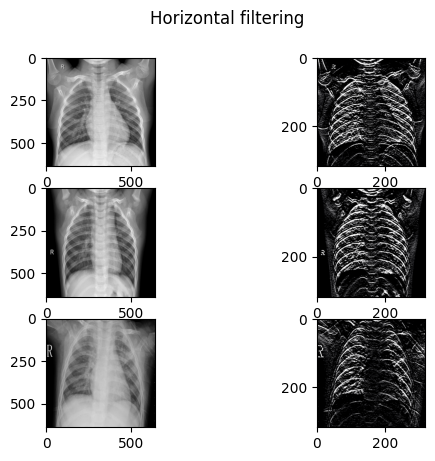

In [14]:
fig, axs = plt.subplots(3,2)
fig.suptitle('Horizontal filtering')
axs[0,0].imshow(im1)
axs[0,1].imshow(im1_new.astype(int))
axs[1,0].imshow(im2)
axs[1,1].imshow(im2_new.astype(int))
axs[2,0].imshow(im3)
axs[2,1].imshow(im3_new.astype(int))
plt.show()

Here we see that the horizontal filter is working as intended, highlighting the ribcage, shoulder bones and lower jaw. This filter is not very useful in this case, as it makes the skeleton more prominent and gives less info about the lungs.

### **Gaussian filter** <a id="gaussian_filter"></a>

After some experimenting, I chose sigma = 6 because smaller values clipped the white values of the images, resulting in the brightness increasing. I think the same thing is happening with the horizontal filter, where the range goes from 0 -- 255 to -6400 -- 6400. I think this comes from the horizontal filter being small compared to the input, so there is a lot of contrast density.

Mu = 0 because the mean has to be in the center of the filter for it to work correctly.

In [15]:
def gauss_filter(k,img,b,hparameters):
    kc = (k-1)/2
    filter = np.zeros((k,k)) # Empty array
    sigma = 6 
    
    for i in range(0,k):
        for j in range(0,k):
            filter[i,j] = (1/(2.0*np.pi*sigma**2))*np.exp(-(((i-kc)**2)+(j-kc)**2)/sigma**2) # Using the equation from the lecture slides
    filter = np.stack([filter,filter,filter],axis=2)
    filter = np.stack([filter,filter,filter],axis=2)
    Z,cache_conv = conv_forward(img,filter,b,hparameters)

    return Z,cache_conv

In [16]:
Z_gauss,cache_gauss = gauss_filter(11,batch,b,hparameters)

In [17]:
im1_gauss, im2_gauss, im3_gauss = tuple(np.moveaxis(Z_gauss, 0, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1..237].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1..230].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1..208].


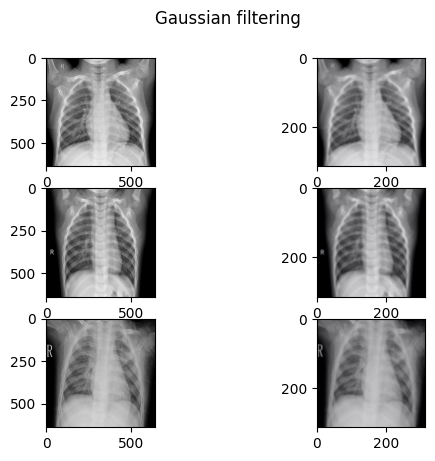

In [18]:
fig, axs = plt.subplots(3,2)
fig.suptitle('Gaussian filtering')
axs[0,0].imshow(im1)
axs[0,1].imshow(im1_gauss.astype(int))
axs[1,0].imshow(im2)
axs[1,1].imshow(im2_gauss.astype(int))
axs[2,0].imshow(im3)
axs[2,1].imshow(im3_gauss.astype(int))
plt.show()

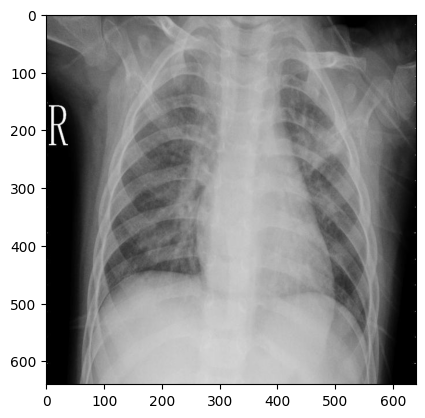

In [19]:
plt.imshow(im3)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1..208].


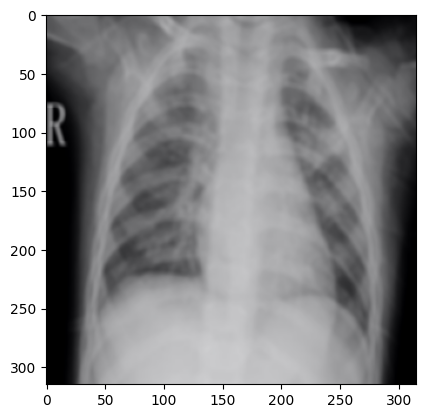

In [20]:
plt.imshow(im3_gauss.astype(int))
plt.show()

### **Sharpening filter** <a id="sharpening_filter"></a>

I have used a value of 4.35 in the sharpening kernel after some experimenting. With a value of 5, the sharpening was too dramatic and over exposed the image. Smaller values, like 4, are better suited for ridge detection.

In [21]:
def sharp_filter(k,img,b,hparameters):
    filter = np.array([[0,-1,0],[-1,4.35,-1],[0,-1,0]]) # 3x3 sharpening filter
    filter = np.stack([filter,filter,filter],axis=2) # The filter is stacked twice, to get a (3,3,3,3) size tensor
    filter = np.stack([filter,filter,filter],axis=2)
    Z,cache_conv = conv_forward(img,filter,b,hparameters) # Filter is used in convolution

    return Z,cache_conv

In [22]:
Z_sharp,cache_sharp = sharp_filter(11,batch,b,hparameters)

In [23]:
im1_sharp, im2_sharp, im3_sharp = tuple(np.moveaxis(Z_sharp, 0, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1006..1256].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1474..1312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1002..1788].


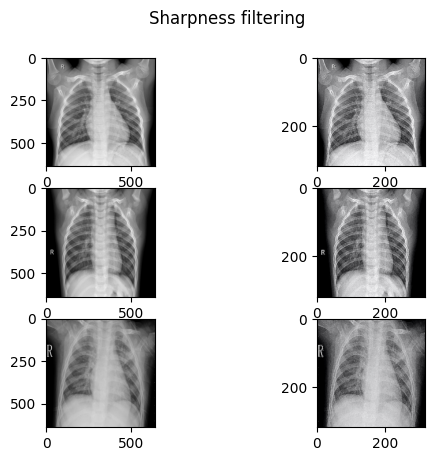

In [24]:
fig, axs = plt.subplots(3,2)
fig.suptitle('Sharpness filtering')
axs[0,0].imshow(im1)
axs[0,1].imshow(im1_sharp.astype(int))
axs[1,0].imshow(im2)
axs[1,1].imshow(im2_sharp.astype(int))
axs[2,0].imshow(im3)
axs[2,1].imshow(im3_sharp.astype(int))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1006..1256].


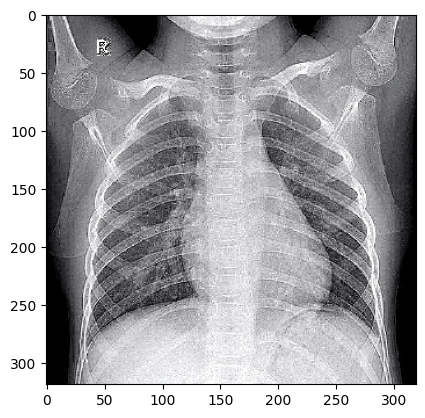

In [25]:
plt.imshow(im1_sharp.astype(int))
plt.show()

## **Convolusion Network** <a id="convolusion_network"></a>

For the CCN I am using a modified AlexNet with skip connection. There is no particular reason, other than that AlexNet is good at classification and the xray images are big, compared to MNIST atleast.

In [26]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset,DataLoader
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),   
    transforms.ToTensor() 
])


AlexNet expects 224 pixel images, so here I am resizing the images.

With the first block, the output shape is (224+2-11)/4 + 1 = 54.75. If you take the shape to be 55, then the size of x3 should be 6x6, but that is not what the shape of x3 is in the code, as in the code it is 5x5. You can only get that if you only take the integer from 54.75 ie 54. Then you get a final shape of 5x5. 

I'm assuming this difference comes from the way that nn.conv2d calculates convolutions and matrix sizes.

In [27]:
import torch.nn.functional as F

class AlexNetWithSkip(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNetWithSkip, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=1)  # This is where x1 ends
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)  # x3 ends here
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 5 * 5, 4096),  # Adjusted for output size of 5x5
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x1 = self.block1(x)  # Shape: [batch_size, 256, 26, 26] 
        x2 = self.block2(x1)  # Shape: [batch_size, 256, 12, 12]
        x3 = self.block3(x2)  # Shape: [batch_size, 256, 5, 5]

        # Resize x1 to match the spatial size of x3 (5x5)
        x1_resized = F.interpolate(x1, size=(5, 5), mode='bilinear', align_corners=False)
        
        # Now, x1_resized and x3 have the same size, so you can apply the skip connection
        x3 += x1_resized
        
        # Pass through the fully connected layers
        out = self.fc(x3)
        return out

In [28]:
from torch import optim

class DatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        
        image = example["image"] 
        label = example["labels"] 

        if self.transform:
            image = self.transform(image)

        return image, label

# Wrap the dataset in the custom wrapper
train_dataset = DatasetWrapper(ds["train"], transform=transform)
val_dataset = DatasetWrapper(ds["validation"], transform=transform)

# DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize the model, loss function, and optimizer
model = AlexNetWithSkip(num_classes=2) 
model = model.to(device)  # Move the model to GPU if available

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [29]:
# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
full_time = 0

epochs = 15  # Number of epochs to train
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    elapsed_time = 0
    start_time = time.time()

    # Iterate over batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics for this batch
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    # Print statistics after each epoch and add to list
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Validation phase after each epoch
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    full_time += end_time - start_time
    
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Elapsed Time: {full_time:.4f}")


Epoch [1/15], Loss: 0.6970, Accuracy: 72.87%
Validation Loss: 0.3477, Validation Accuracy: 85.15%, Elapsed Time: 25.7950
Epoch [2/15], Loss: 0.4315, Accuracy: 80.87%
Validation Loss: 0.3396, Validation Accuracy: 89.10%, Elapsed Time: 52.3326
Epoch [3/15], Loss: 0.3349, Accuracy: 86.04%
Validation Loss: 0.3023, Validation Accuracy: 84.98%, Elapsed Time: 77.7453
Epoch [4/15], Loss: 0.2791, Accuracy: 88.99%
Validation Loss: 0.2000, Validation Accuracy: 92.62%, Elapsed Time: 102.7766
Epoch [5/15], Loss: 0.2901, Accuracy: 88.05%
Validation Loss: 0.2187, Validation Accuracy: 91.67%, Elapsed Time: 128.2828
Epoch [6/15], Loss: 0.2418, Accuracy: 90.88%
Validation Loss: 0.1944, Validation Accuracy: 93.30%, Elapsed Time: 154.4491
Epoch [7/15], Loss: 0.2948, Accuracy: 89.01%
Validation Loss: 0.1892, Validation Accuracy: 91.93%, Elapsed Time: 180.3179
Epoch [8/15], Loss: 0.2402, Accuracy: 90.19%
Validation Loss: 0.1723, Validation Accuracy: 93.56%, Elapsed Time: 206.9888
Epoch [9/15], Loss: 0.2672,

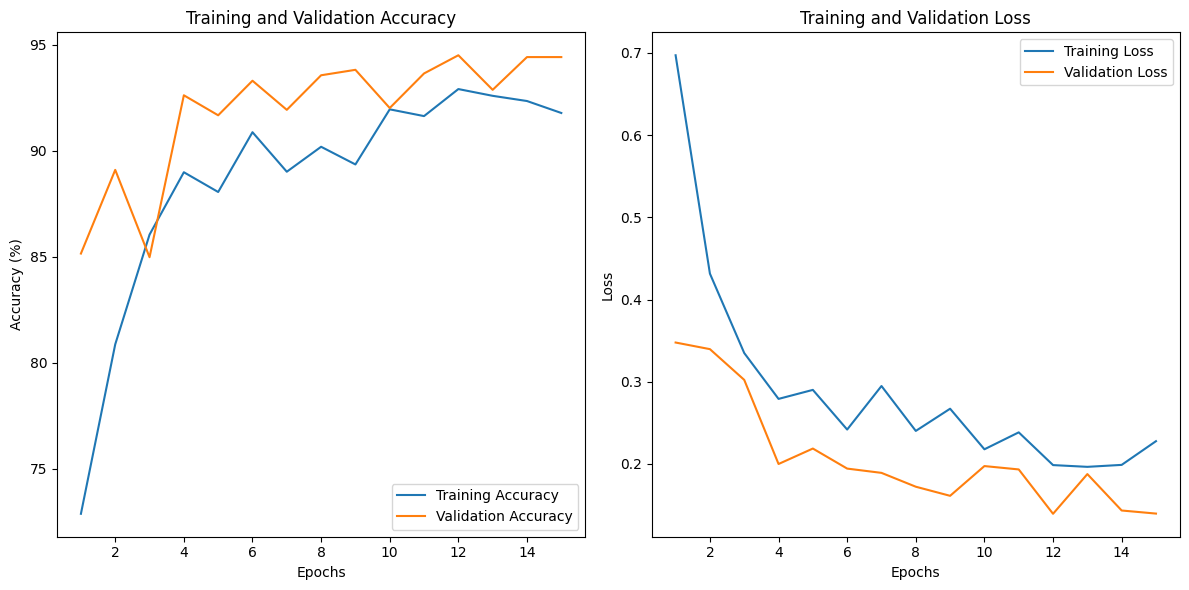

In [30]:
epochs = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

The model previously had 25 epochs which is a lot and took around 11 min to load. The accuracy stabilizes aroun 95%, which is pretty good.


## **Transfer Learning** <a id="transfer_learning"></a>

In [30]:
import cv2
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)


('dog.jpg', <http.client.HTTPMessage at 0x228a6899fd0>)

In [33]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)


Using cache found in C:\Users\rvaal/.cache\torch\hub\intel-isl_MiDaS_master
C:\Users\rvaal\Documents\Deep_Learning\venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [35]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


Using cache found in C:\Users\rvaal/.cache\torch\hub\intel-isl_MiDaS_master


In [36]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(im1).to(device)


In [37]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()


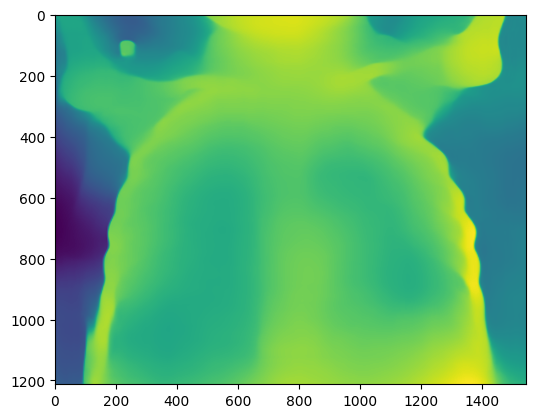

In [38]:
plt.imshow(output)
plt.show()

## **YOLO** <a id="YOLO"></a>

In [39]:
#git clone https://github.com/ultralytics/yolov5  
#cd yolov5
%pip install -r C:\Users\rvaal\Documents\Deep_Learning\Project_2\yolov5\requirements.txt  

  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
  Using cached ultralytics-8.3.39-py3-none-any.whl.metadata (35 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached ultralytics_thop-2.0.12-py3-none-any.whl.metadata (9.4 kB)
Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
Using cached ultralytics-8.3.39-py3-none-any.whl (896 kB)
Using cached ultralytics_thop-2.0.12-py3-none-any.whl (26 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
Note: you may need to restart the kernel to use updated packages.


In [40]:
!python C:\Users\rvaal\Documents\Deep_Learning\Project_2\yolov5\detect.py --source C:\Users\rvaal\Documents\Deep_Learning\images

detect: weights=yolov5\yolov5s.pt, source=C:\Users\rvaal\Documents\Deep_Learning\images, data=yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-388-g882c35fc Python-3.12.7 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/6 C:\Users\rvaal\Documents\Deep_Learning\images\IM-0083-0001_jpeg.rf.d54159b6ea9b8ff827b74e6694c966f5.jpg: 640x640 1 person, 101.7ms
image 2/6 C:\Users\rvaal\Documents\Deep_Learning\images\IM-0245-0001_jpeg.rf.ee306f59722124ec99c1bbb5e6858cc5.jpg: 640x640 1 person, 91.8ms
image 3/6 C:\Users\rvaal\Documents\D

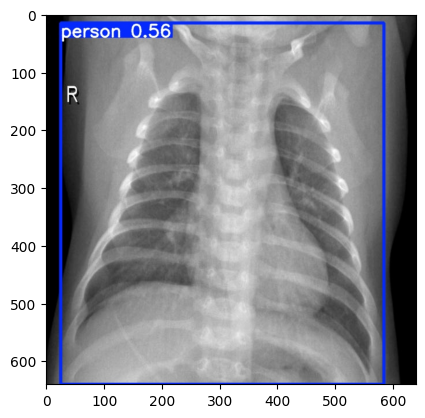

In [41]:
from PIL import Image

img = Image.open(r'yolov5\runs\detect\exp3\IM-0083-0001_jpeg.rf.d54159b6ea9b8ff827b74e6694c966f5.jpg')
plt.imshow(img)
plt.show()

YOLO is not very useful in this instance as every picture is of a person. There are better YOLO repos that are more geared towards x ray classification but looking at the few that I did, they seemed to be fit for an entire project themselves, so I will not delve too deep on this. This model could be improved if I found/used custom labels that gave bounding boxes for pneumonia and normal cases but this would take a long time and probably wouldn't give better results than the AlexNet model.

The issue of not having correct labels is also the reason why I have not done much transfer learning. I found one x ray classification model on kagglehub, but for some reason kagglehub doesn't want to work. Other models are trained on very different data (people, vehicles, birds) and I don't think they would give any good results in this context. 

## **Transfer Learning vol.2** <a id="transfer_learning_vol.2"></a>

In [48]:
import torch
model_s = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)
model_s.eval()
model_s.to('cuda')

Using cache found in C:\Users\rvaal/.cache\torch\hub\pytorch_vision_v0.10.0


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [49]:
# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
full_time = 0

epochs = 5  # Number of epochs to train
for epoch in range(epochs):
    model_s.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    elapsed_time = 0
    start_time = time.time()

    # Iterate over batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_s(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics for this batch
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    # Print statistics after each epoch and add to list
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Validation phase after each epoch
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_s(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    full_time += end_time - start_time
    
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Elapsed Time: {full_time:.4f}")


Epoch [1/5], Loss: 8.7021, Accuracy: 0.02%
Validation Loss: 8.4925, Validation Accuracy: 0.09%, Elapsed Time: 23.6919
Epoch [2/5], Loss: 8.6970, Accuracy: 0.00%
Validation Loss: 8.4925, Validation Accuracy: 0.09%, Elapsed Time: 46.9610
Epoch [3/5], Loss: 8.6937, Accuracy: 0.00%
Validation Loss: 8.4925, Validation Accuracy: 0.09%, Elapsed Time: 73.6724
Epoch [4/5], Loss: 8.6960, Accuracy: 0.00%
Validation Loss: 8.4925, Validation Accuracy: 0.09%, Elapsed Time: 99.4201
Epoch [5/5], Loss: 8.7019, Accuracy: 0.00%
Validation Loss: 8.4925, Validation Accuracy: 0.09%, Elapsed Time: 122.7027


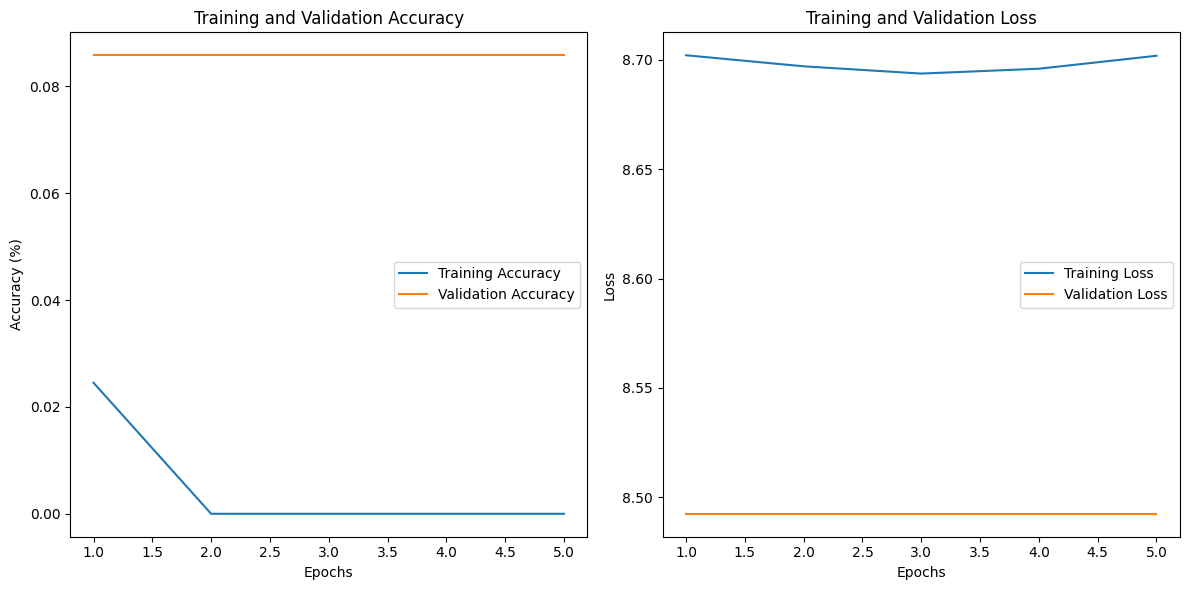

In [50]:
epochs = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()